# Problem Introduction

## Dataset Description & Loading


### Appliances Energy Prediction Dataset

The **Appliances Energy Prediction Dataset** consists of **19,735 time-series measurements**, collected at **10-minute intervals** over approximately **4.5 months** in a low-energy smart home. Each observation includes **28 features** derived from environmental sensors, energy meters, and external weather stations.

#### 📌 Features Overview

- **Indoor conditions (continuous):**  
  - **Temperatures (°C):** `T1` to `T9` (e.g., kitchen, living room, bathroom, bedrooms, outside north wall, etc.)  
  - **Humidity (%):** `RH_1` to `RH_9` (same locations as temperature sensors)  

- **Weather station variables (continuous):**  
  - `T_out` (outdoor temperature), `RH_out` (outdoor humidity), `Press_mm_hg` (pressure),  
    `Windspeed`, `Visibility`, `Tdewpoint` (dew point temperature)

- **Other numerical variables (continuous):**  
  - `lights` (energy usage in Wh), `rv1`, `rv2` (non-dimensional random variables)

- **Target variable (continuous):**  
  - `Appliances` (energy consumption in Wh)

#### 🛠️ Data Characteristics

- No missing values
- Measurements collected via ZigBee sensors and M‑Bus energy meters
- Weather data merged from Chievres Airport (Belgium)
- Dataset donated in February 2017
- Introduced and analyzed in a study by Candanedo et al. (2017)
- Commonly used for regression-based energy forecasting and time-series modeling

**Source:** [UCI Machine Learning Repository - Appliances Energy Prediction](https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from scipy.signal import spectrogram
from models.predict_model import eval_model
import random
from data.make_dataset import load_dataset

from models.train_model import fit_model
from models.lstm import LSTMForecaster
from models.transformer import TransfForecaster
from models.tcn import TCNForecaster

# Fix Random Seed
RANDOM_SEED = 18

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# For CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)

# For MPS (Apple Silicon) or general determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


df = load_dataset()

# EDA

## Data Cleaning

Checking for missing or NaN values

In [3]:
feature_names = df.columns

# Check for missing values or NaNs
missing_values = df.isnull().sum()
nan_values = df.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])
print("\nNaN values per column:\n", nan_values[nan_values > 0])

Missing values per column:
 Series([], dtype: int64)

NaN values per column:
 Series([], dtype: int64)


## Data Visualization

### 📉 Sample Feature Trends (First Week)

This panel shows the **temporal dynamics** of key features. Indoor variables (e.g., `T1`, `RH_1`, `lights`) reflect daily patterns and user activity, while outdoor variables (e.g., `T_out`, `Windspeed`, `Pressure`) show natural environmental changes. The target (`Appliances`) displays **bursty usage patterns**, supporting the need for time-aware models.

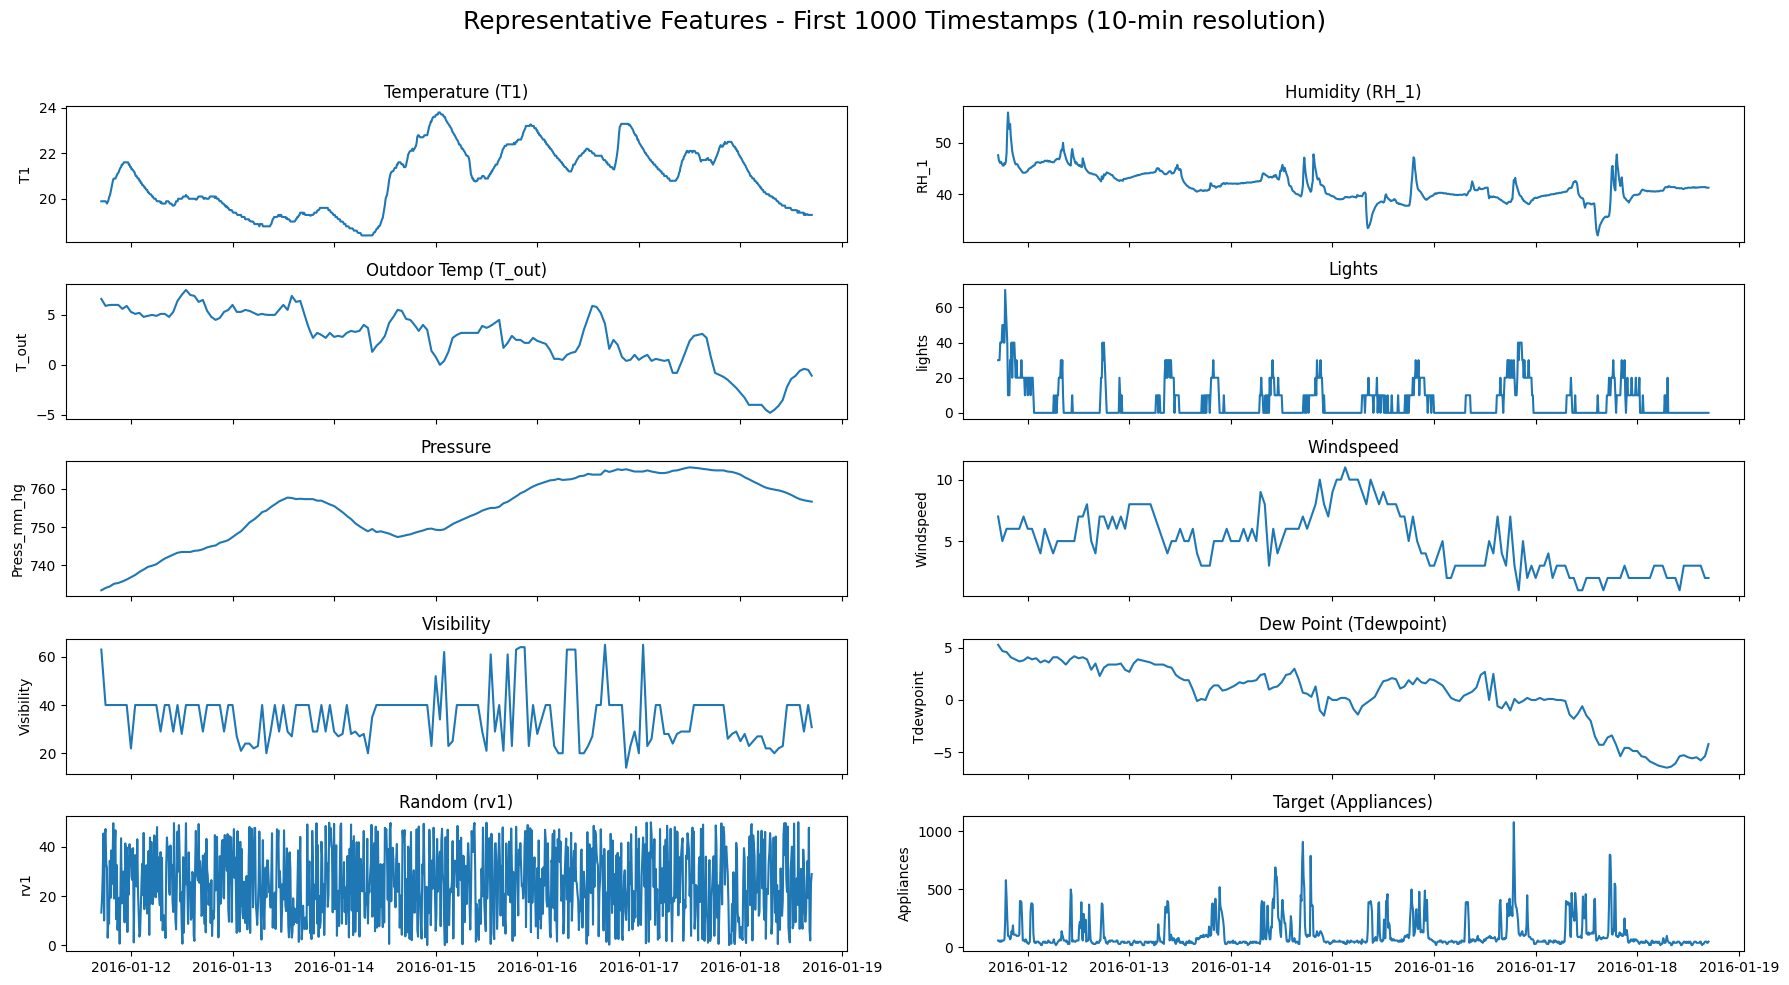

In [4]:
# Use only the first week
df_subset = df.iloc[:144*7]

# Select features to plot
selected_features = {
    "Temperature (T1)": "T1",
    "Humidity (RH_1)": "RH_1",
    "Outdoor Temp (T_out)": "T_out",
    "Lights": "lights",
    "Pressure": "Press_mm_hg",
    "Windspeed": "Windspeed",
    "Visibility": "Visibility",
    "Dew Point (Tdewpoint)": "Tdewpoint",
    "Random (rv1)": "rv1",
    "Target (Appliances)": "Appliances"
}

# Plot 3x4 grid
fig, axes = plt.subplots(5, 2, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, (label, col) in enumerate(selected_features.items()):
    axes[i].plot(df_subset.index, df_subset[col])
    axes[i].set_title(label)
    axes[i].set_ylabel(col)

# Hide unused subplots
for j in range(len(selected_features), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Representative Features - First 1000 Timestamps (10-min resolution)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 🔌 Appliance Energy Usage Distribution

The target variable `Appliances` shows a **right-skewed distribution**, with most energy usage values below **200 Wh** and occasional high peaks above **1000 Wh**. This suggests infrequent but significant bursts in consumption, likely during periods of high appliance usage.

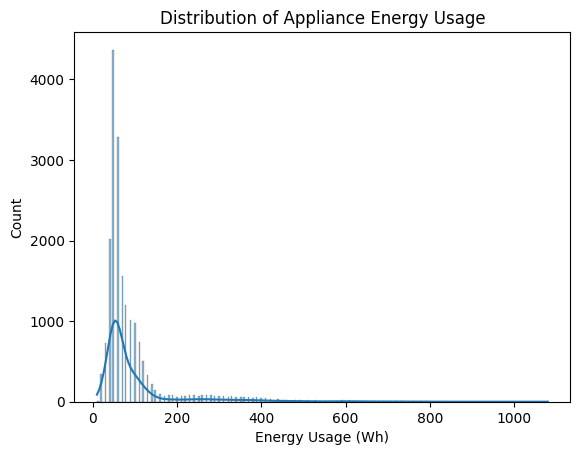

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["Appliances"], kde=True)
plt.title('Distribution of Appliance Energy Usage')
plt.xlabel('Energy Usage (Wh)')
plt.show()

### Feature Relationship Analysis

We analyzed the relationships among variables in the **Appliances Energy Prediction** dataset using a **correlation matrix**:

**Correlation Matrix** (linear dependencies):
- Strong positive correlations are observed among indoor temperature sensors (`T1` to `T9`), reflecting similar thermal trends across different rooms.
- Relative humidity sensors (`RH_1` to `RH_9`) also show moderate correlations, especially among those located in the same area.
- The `Appliances` variable shows weak linear correlations with most features, suggesting that energy consumption may be driven by **nonlinear relationships** or **external factors** not captured by simple correlation.
- As expected, `rv1` and `rv2` are **perfectly correlated** with each other, but **uncorrelated** with the remaining features.

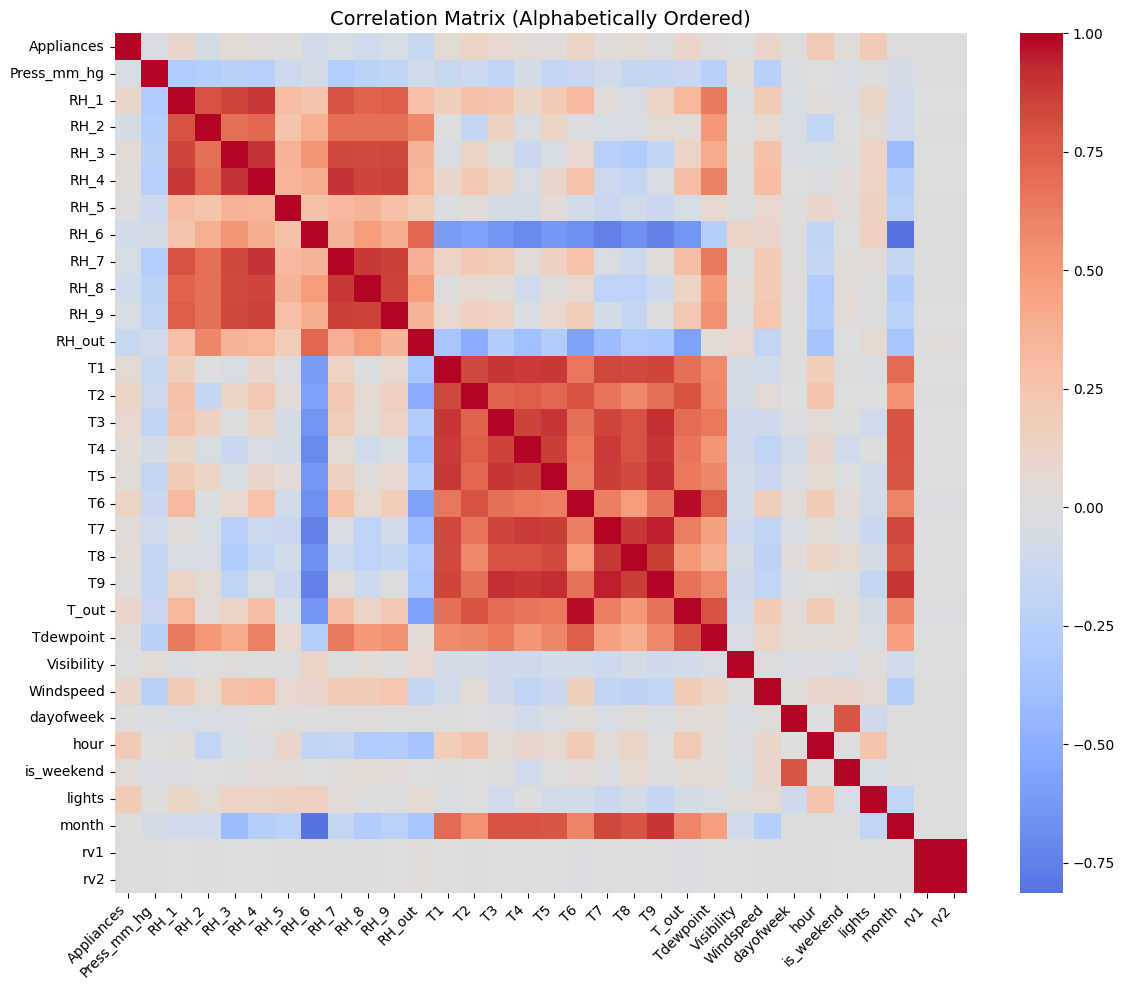

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr()

# Sort correlation matrix by alphabetical order of columns
sorted_cols = sorted(corr.columns)
corr_sorted = corr.loc[sorted_cols, sorted_cols]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_sorted, cmap='coolwarm', annot=False, center=0)
plt.title('Correlation Matrix (Alphabetically Ordered)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Temporal Structure of Appliance Energy Consumption

The autocorrelation plot of the target variable (`Appliances`) reveal key temporal dependencies:

- **Autocorrelation (ACF)** shows strong positive correlations at short lags (1–10), indicating that recent past values are highly predictive of current consumption.
- A clear **cyclical pattern emerges around lag 144**, which corresponds to 24 hours of data at 10-minute intervals. This suggests a strong **daily seasonality** in appliance usage, likely driven by human activity patterns.


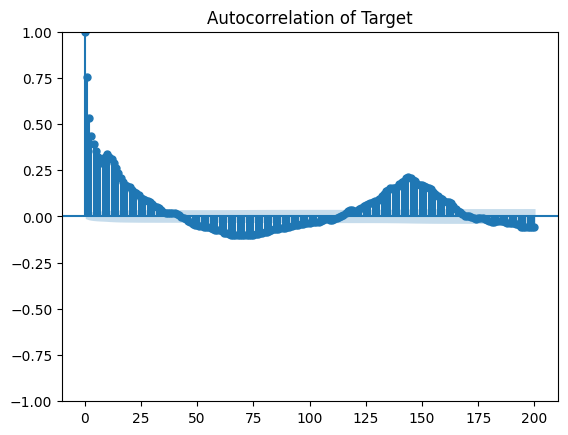

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["Appliances"].squeeze(), lags=200)
plt.title("Autocorrelation of Target")
plt.show()

## Non-Stationary Verification

### Visual Methods

A visual inspection of the time series through multiple analytical perspectives reveals clear signs of **non-stationarity**:

- **Time Series Plot**: The raw time series shows large variability in amplitude over time and visually distinct daily peaks, suggesting non-constant mean and variance.

- **Rolling Statistics**: The rolling mean and standard deviation fluctuate considerably across time, further indicating that the statistical properties of the series are not stable.

- **Seasonal Decomposition**: The decomposition reveals a strong and regular **seasonal component** (daily cycles) and a non-constant **trend**, both of which violate the assumption of stationarity.

- **Autocorrelation (ACF)**: The ACF decays slowly and exhibits periodic spikes, suggesting long-term dependencies and seasonality in the data, common in non-stationary series.

- **FFT and Spectrogram (STFT)**: Both frequency-domain analyses highlight dominant frequencies corresponding to **daily and sub-daily periodicities**, which are typical of non-stationary signals with repetitive behavior over time.

**Conclusion**: The energy consumption series shows **time-varying mean**, **seasonality**, and **long-term structure**, confirming it is **not stationary**. This justifies the need for transformations (e.g., differencing, seasonal adjustment, log transforms) before applying models that assume stationarity.

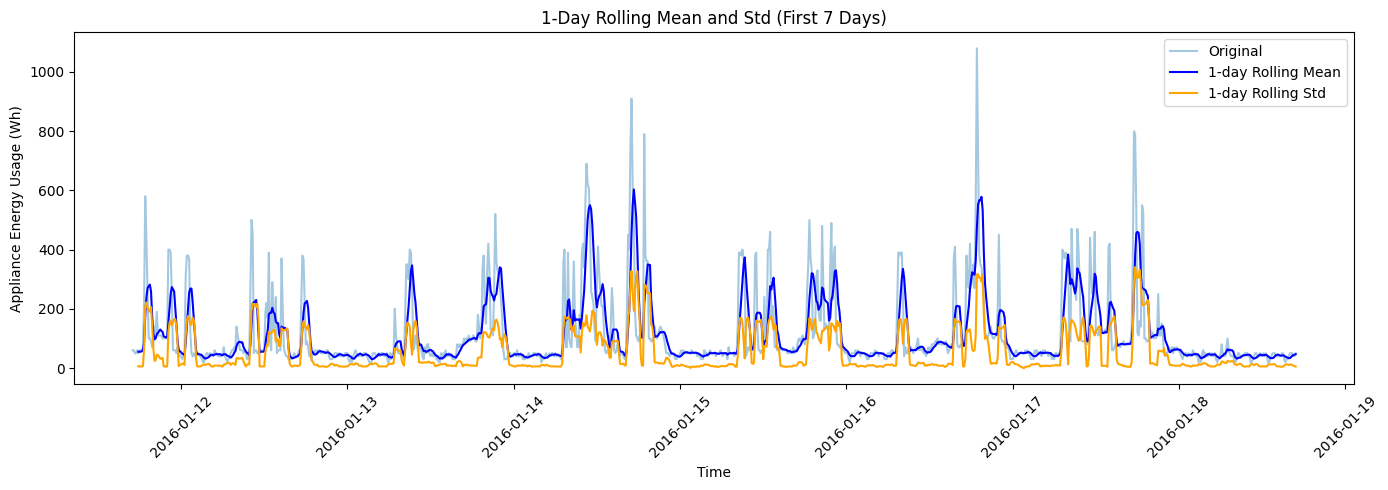

In [8]:
# Define time window (10-minute resolution)
window = 6

# Compute rolling statistics
roll_mean = df["Appliances"].rolling(window=window).mean()
roll_std = df["Appliances"].rolling(window=window).std()

# Select first 7 days (7*144 = 1008 samples)
end_date = df.index[0] + pd.Timedelta(days=7)
signal_7d = df.loc[df.index < end_date, "Appliances"]
roll_mean_7d = roll_mean.loc[signal_7d.index]
roll_std_7d = roll_std.loc[signal_7d.index]

# Plot rolling statistics
plt.figure(figsize=(14, 5))
plt.plot(signal_7d, label='Original', alpha=0.4)
plt.plot(roll_mean_7d, label='1-day Rolling Mean', color='blue')
plt.plot(roll_std_7d, label='1-day Rolling Std', color='orange')
plt.legend()
plt.title("1-Day Rolling Mean and Std (First 7 Days)")
plt.xlabel("Time")
plt.ylabel("Appliance Energy Usage (Wh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

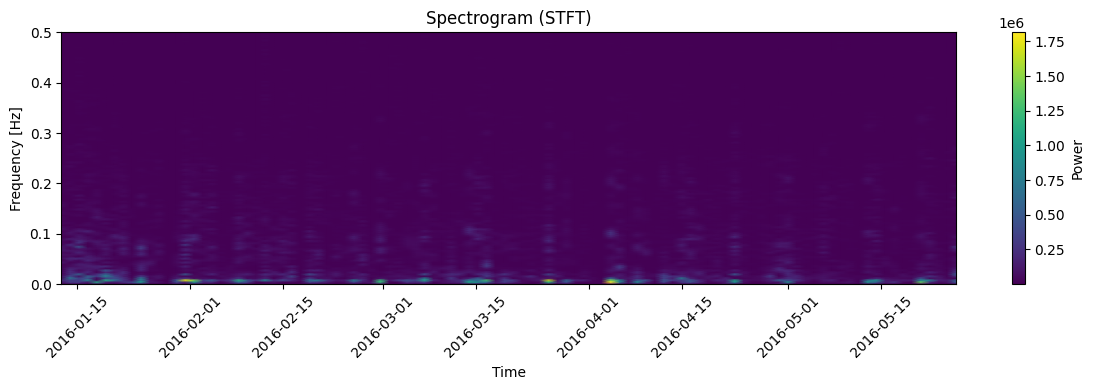

In [9]:
# Compute spectrogram
fs = 1.0  # 1 sample per step (10 minutes per sample)
f, t, Sxx = spectrogram(np.ravel(df["Appliances"]), fs=fs, nperseg=256, noverlap=64)

# Map t to timestamps (each unit in t is one 10-minute step)
timestamps = df.index[0] + pd.to_timedelta(t * 10, unit='min')

# Plot spectrogram with time labels
plt.figure(figsize=(12, 4))
plt.pcolormesh(timestamps, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time')
plt.title('Spectrogram (STFT)')
plt.colorbar(label='Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Quantitative Tests

### 📊 ADF Test Comparison — Global vs. Local Stationarity

We performed two types of Augmented Dickey-Fuller (ADF) tests to assess the stationarity of the `Appliances` energy consumption time series:

---

#### 🧪 1. Standard (Global) ADF Test

- **ADF Statistic:** –21.62  
- **p-value:** 0.0000  
- ✅ **Conclusion:** Rejects the null hypothesis of non-stationarity → the series is **globally stationary**.

However, this result may be **misleading**, as the signal clearly exhibits **daily seasonality and trend components**, as shown in the seasonal decomposition and FFT analysis.

---

#### 🔁 2. Rolling ADF Test (Local, 4-Hour Window)

- Applied ADF in a moving window over the **first 10 days** using a **4-hour window** stepped every 100 minutes.
- The **p-value fluctuates** significantly, frequently **crossing above and below the 0.05 threshold**.
- This suggests **intermittent (local) stationarity** and temporal variation in the statistical properties of the signal.

---

### 📌 Key Takeaways

- The **global ADF test falsely suggests full stationarity**, likely due to strong seasonal patterns.
- The **rolling ADF test provides a more nuanced view**, revealing that the signal is **non-stationary in many local segments**, especially during volatile consumption periods.

In [10]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the target variable
adf_result = adfuller(df["Appliances"])
adf_statistic, p_value, lags, n_obs, crit_values, ic_best = adf_result

print(f"ADF Statistic: {adf_statistic:.4f}")
print(f"p-value: {p_value:.4g}")
print(f"# Lags Used: {lags}")
print(f"# Observations: {n_obs}")
print("Critical Values:")
for k, v in crit_values.items():
    print(f"   {k}: {v:.4f}")
print(f"Best Information Criterion (IC): {ic_best:.2f}")

ADF Statistic: -21.6164
p-value: 0
# Lags Used: 11
# Observations: 19723
Critical Values:
   1%: -3.4307
   5%: -2.8617
   10%: -2.5668
Best Information Criterion (IC): 220573.75


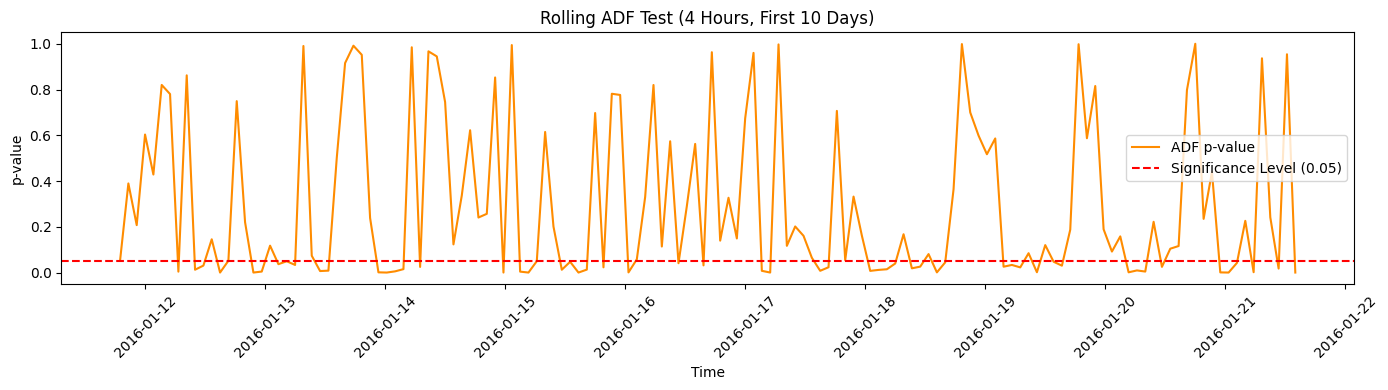

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Define parameters
samples_per_day = 144  # 10-min intervals
window_size = 24  # 4 hours
step = 10  # slide by 10 time steps = 100 minutes
max_samples = samples_per_day * 10  # First 10 days = 1440 samples

# Store p-values and timestamps
pvals = []
stats = []
timestamps = []

# Rolling ADF loop only for the first 10 days
for start in range(0, max_samples - window_size, step):
    end = start + window_size
    segment = df["Appliances"].iloc[start:end]
    
    try:
        stat, p, *_ = adfuller(segment)
        pvals.append(p)
        stats.append(stat)
        timestamps.append(df.index[start + window_size // 2])
    except:
        pvals.append(np.nan)
        stats.append(np.nan)
        timestamps.append(df.index[start + window_size // 2])

# Plot p-values
plt.figure(figsize=(14, 4))
plt.plot(timestamps, pvals, label="ADF p-value", color='darkorange')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.title("Rolling ADF Test (4 Hours, First 10 Days)")
plt.xlabel("Time")
plt.ylabel("p-value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Decomposition Analysis

### 🔁 Frequency Analysis with FFT

We applied the **Fast Fourier Transform (FFT)** to the `Appliances` time series (after mean-centering) to identify dominant periodic patterns. The frequency spectrum reveals a clear peak at a non-zero frequency, corresponding to a **season length of 145 samples**, which closely aligns with **1 day** (144 samples at 10-minute intervals).

This confirms the presence of a strong **daily consumption cycle**, consistent with expected household energy usage patterns.

In [12]:
from scipy.fft import fft
import numpy as np

n = len(df["Appliances"])
y_fft = fft(df["Appliances"] - np.mean(df["Appliances"]))
freqs = np.fft.fftfreq(n)
peak_freq = abs(freqs[np.argmax(np.abs(y_fft[1:n//2]))])  # avoid 0 frequency
season_length = int(round(1 / peak_freq))
print("FFT estimated season length:", season_length)


FFT estimated season length: 145


### 📊 FFT Magnitude Spectrum

The **FFT magnitude spectrum** reveals strong periodic patterns in the `Appliances` energy usage. A sharp peak appears around the **24-hour period (1 day)**, confirming the dominant **daily consumption cycle**. Additional peaks near 12 h and 6 h suggest possible sub-daily routines (e.g., cooking, heating). The x-axis is shown in **log-scale of time (inverted)**, making it easy to interpret daily and weekly frequencies.


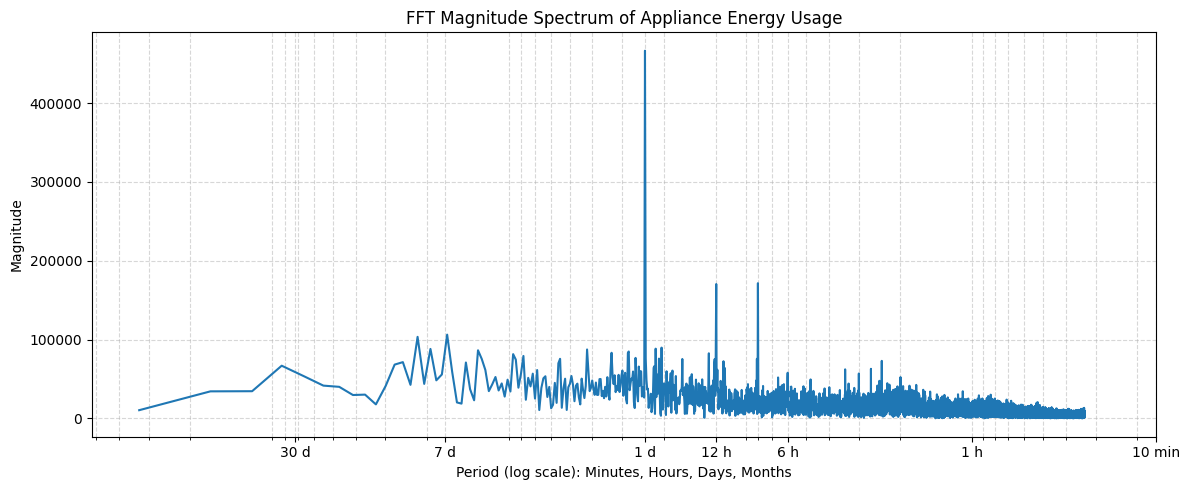

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Compute FFT
y = df["Appliances"].values
y_fft = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(y), d=600)  # 10-minute interval = 600s

# Positive frequencies only
mask = frequencies > 0
freqs = frequencies[mask]
magnitudes = np.abs(y_fft)[mask]

# Convert frequency to period in seconds
periods_sec = 1 / freqs
periods_hours = periods_sec / 3600

# Plot
plt.figure(figsize=(12, 5))
plt.plot(periods_hours, magnitudes)
plt.title("FFT Magnitude Spectrum of Appliance Energy Usage")
plt.xlabel("Period (log scale): Minutes, Hours, Days, Months")
plt.ylabel("Magnitude")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid(True, which="both", ls="--", alpha=0.5)

# Custom ticks (in hours)
custom_ticks = [1/6, 1, 6, 12, 24, 24*7, 24*30]  # 10min, 1h, 6h, 12h, 1d, 7d, 30d
custom_labels = ['10 min', '1 h', '6 h', '12 h', '1 d', '7 d', '30 d']

plt.xticks(custom_ticks, custom_labels)
plt.tight_layout()
plt.show()

### 📈 Seasonal Decomposition (Additive Model)

Using a decomposition with **daily periodicity (season_length = 144)**, the `Appliances` signal is broken into:

- **Trend:** Captures the longer-term variation in energy usage across weeks.
- **Seasonal:** Shows the **strong and regular daily oscillation**, matching the 24-hour cycle.
- **Residual:** Contains noise and irregular patterns not explained by trend or seasonality.

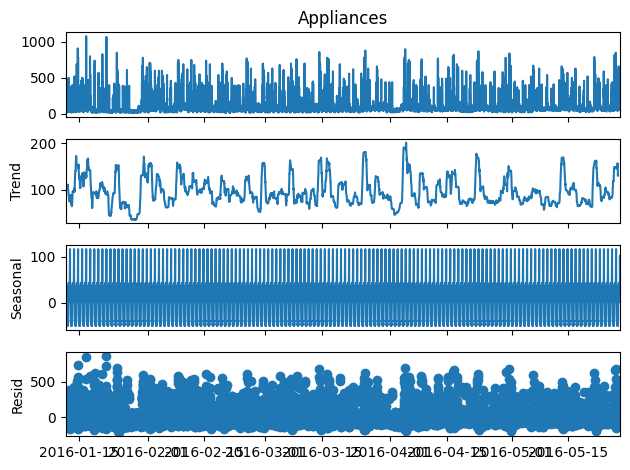

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

season_length = 144
decomp = seasonal_decompose(df["Appliances"], period=season_length, model='additive')  # adjust `season_length`
decomp.plot()
plt.show()

# Time Series Regression Task: Forecasting Appliance Energy Usage

### 📐 Problem Definition

The goal of this regression task is to **predict future appliance energy consumption** based on past multivariate environmental and contextual features. The target variable is the normalized energy usage (`Appliances`) recorded every 10 minutes.

To frame this as a supervised learning problem, we used a **sliding-window approach** implemented via a custom `SeqDataset`. Each training sample consists of:
- An **input window** (`input_len = 5 days`, i.e., 720 timesteps) of past observations (`X` features)
- A **forecasting horizon** (`horizon = 100 steps`) representing the future values of the target `y`

A key parameter in this construction is the **`stride`**, which controls the step size between consecutive samples:
- A stride of `72` (equivalent to 12 hours) reduces overlap and balances dataset size vs. temporal coverage

In addition to the continuous variables, **categorical time-based features** such as `hour`, `dayofweek`, and `is_weekend` were included in the regression. These features improved performance, highlighting the relevance of temporal context in forecasting appliance energy usage.

---

### 🧪 Data Normalization and Splitting

Before creating the sliding sequences, the data is **standardized**:
- A `StandardScaler` is fit **only on the training portion** (first 80% of the time series)
- Both features (`X`) and target (`y`) are scaled using this strategy to prevent data leakage

---

### 🧪 Train/Test Split Strategy

To preserve the temporal structure, the time series is not shuffled. Instead:
- The dataset is split so that the final 20% of the samples (i.e., the most recent observations) are reserved exclusively for testing
- This mimics a realistic forecasting setup where the model predicts the future based only on the past

This strategy ensures that all test samples are temporally after the training samples, maintaining causality and simulating real-world inference.

---

### 🧰 Model Selection

We trained and compared the following three deep learning architectures, suitable for sequence-to-sequence regression:

- **LSTM (Long Short-Term Memory):** Captures long-term dependencies in sequential data.
- **Transformer:** Attention-based model capable of modeling global temporal dependencies.
- **TCN (Temporal Convolutional Network):** Uses causal convolutions and dilation to model temporal structure efficiently.

Each model was trained using the same pipeline: 200 epochs, MAE loss, Adam optimizer, and identical dataloaders.

---

### 📊 KPI Selection

To evaluate performance on the test set, we computed two standard regression metrics:

- **MAE (Mean Absolute Error):** Measures average magnitude of errors (less sensitive to outliers).
- **RMSE (Root Mean Squared Error):** Penalizes large errors more heavily, emphasizing precision.

These KPIs are shown in a summary table to enable **quantitative comparison between models**.

---

### 📈 Results

| Model        | MAE     | RMSE    |
|--------------|---------|---------|
| **LSTM**      | 0.472   | 0.889  |
| **Transformer** | **0.456** | **0.882** |
| **TCN**       | 0.537   | 0.905   |

Comparison of models:
                   MAE      RMSE
lstm         0.472583  0.888938
transformer  0.455955  0.881808
tcn          0.536792  0.904915

From the results:
- The **Transformer** model performs best in both MAE and RMSE, indicating better generalization to future unseen windows.
- LSTM and TCN also perform reasonably well, with slightly higher error margins.

---

### 🔍 Visualizing Predictions

In the final cell, we selected a test sample to visualize predictions over time. The plot compares the ground truth energy usage with the predictions from each model over the 100-step forecasting horizon.

This visual validation helps assess model behavior beyond numeric KPIs, revealing how well the models follow trends, anticipate peaks, or lag behind. The models generally capture the overall energy consumption trend, but they tend to struggle with predicting sudden spikes in usage. Since we are evaluating the energy consumption of a single household, these random increases are difficult to forecast—possibly due to a lack of sufficient information in the dataset to anticipate such events.

---

### 🔁 Training & Evaluation Workflow

The full pipeline follows this modular flowchart:

Train model → Save model → Load model → Evaluate model

This design supports **reproducibility and modular execution**:
- If the models have already been trained and saved to disk, you can **skip the training cell** and directly load and evaluate models using the stored `.pth` weights.
- Evaluation is decoupled from training, making it easy to test additional metrics or visualize different test samples.

---

This workflow provides a flexible, scalable setup for deep time series forecasting and makes it easy to experiment with new models or features.

In [15]:
import torch
import platform

# Device configuration for macOS Metal or CUDA
if torch.backends.mps.is_available() and platform.system() == "Darwin":
    device = torch.device("mps")  # Apple Silicon (Metal Performance Shaders)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

print(f"Using device: {device}")

Using device: mps


In [16]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

y = df['Appliances']                      
X = df.drop(columns=['Appliances'])       

# 1.4. Normalización (fit solo en train)
train_size = int(len(y)*0.8)
scaler_X = StandardScaler().fit(X.iloc[:train_size])
scaler_y = StandardScaler().fit(y.iloc[:train_size].values.reshape(-1,1))
Xs = scaler_X.transform(X)
ys = scaler_y.transform(y.values.reshape(-1,1)).flatten()

In [17]:
import torch
from torch.utils.data import Dataset

horizon = 100 #144 100
input_len = 144*5
stride = 72

from models.seq_dataloader import SeqDataset

# Crear splits
ds = SeqDataset(Xs, ys, input_len=input_len, horizon=horizon)
n_train = int(len(ds)*0.8)
train_ds, test_ds = torch.utils.data.random_split(ds, [n_train, len(ds)-n_train])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [18]:
# Ensure models directory exists
os.makedirs('../models', exist_ok=True)

# Define your models
models = {
    'lstm': LSTMForecaster(n_feats=Xs.shape[1], horizon=horizon).to(device),
    'transformer': TransfForecaster(n_feats=Xs.shape[1], horizon=horizon).to(device),
    'tcn': TCNForecaster(n_feats=Xs.shape[1], horizon=horizon).to(device)
}

# Map model names to classes
model_classes = {
    'lstm': LSTMForecaster,
    'transformer': TransfForecaster,
    'tcn': TCNForecaster
}

In [19]:

histories = {}

for name, model in models.items():
    print(f"Training {name}...")
    hist = fit_model(model, train_loader, test_loader, device, epochs=200, lr=1e-3)
    histories[name] = hist

    # Save model state
    torch.save(model.state_dict(), f'../models/{name}.pth')
    
    # Plot and save training loss
    plt.figure()
    plt.plot(hist['train_loss'], label='train_loss')
    plt.title(f"{name.upper()} Training Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../models/{name}_train_loss.png')
    plt.close()

print("Training complete. Models and plots saved in 'models/' folder.")


Training lstm...
Ep 50/200 — Loss: 0.3569
Ep 100/200 — Loss: 0.3042
Ep 150/200 — Loss: 0.2537
Ep 200/200 — Loss: 0.2255
Training transformer...
Ep 50/200 — Loss: 0.3833
Ep 100/200 — Loss: 0.3287
Ep 150/200 — Loss: 0.2836
Ep 200/200 — Loss: 0.2578
Training tcn...
Ep 50/200 — Loss: 0.3336
Ep 100/200 — Loss: 0.2608
Ep 150/200 — Loss: 0.2151
Ep 200/200 — Loss: 0.1835
Training complete. Models and plots saved in 'models/' folder.


In [20]:
results = {}

for name, cls in model_classes.items():
    print(f"Loading and evaluating {name}...")
    # Re-instantiate model and load weights
    model = cls(n_feats=Xs.shape[1], horizon=horizon).to(device)
    model.load_state_dict(torch.load(f'../models/{name}.pth'))

    # Evaluate
    met = eval_model(model, test_loader, device)
    results[name] = met
    print(f"{name.upper()} -> MAE: {met['MAE']:.4f}, RMSE: {met['RMSE']:.4f}")


Loading and evaluating lstm...
LSTM -> MAE: 0.4726, RMSE: 0.8889
Loading and evaluating transformer...
TRANSFORMER -> MAE: 0.4560, RMSE: 0.8818
Loading and evaluating tcn...
TCN -> MAE: 0.5368, RMSE: 0.9049


In [21]:
import pandas as pd
summary = pd.DataFrame({
    name: { 'MAE': met['MAE'], 'RMSE': met['RMSE'] }
    for name, met in results.items()
}).T
print("\nComparison of models:\n", summary)



Comparison of models:
                   MAE      RMSE
lstm         0.472583  0.888938
transformer  0.455955  0.881808
tcn          0.536792  0.904915


In [22]:
# KPI summary
df_kpi = pd.DataFrame({
    'Model': ['LSTM', 'Transformer', 'TCN'],
    'MAE':   [results['lstm']['MAE'], results['transformer']['MAE'], results['tcn']['MAE']],
    'RMSE':  [results['lstm']['RMSE'], results['transformer']['RMSE'], results['tcn']['RMSE']],
})

print(df_kpi)

         Model       MAE      RMSE
0         LSTM  0.472583  0.888938
1  Transformer  0.455955  0.881808
2          TCN  0.536792  0.904915


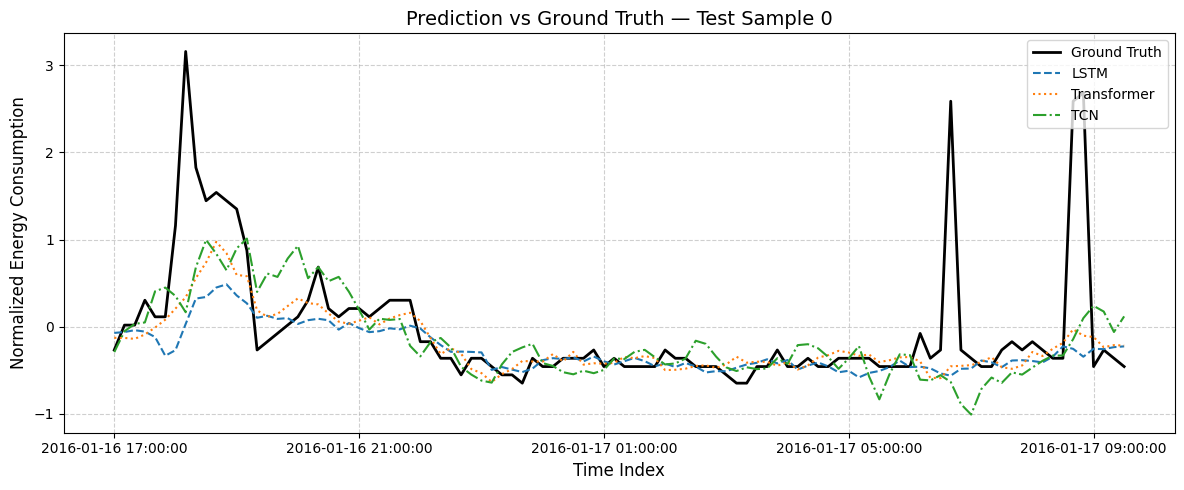

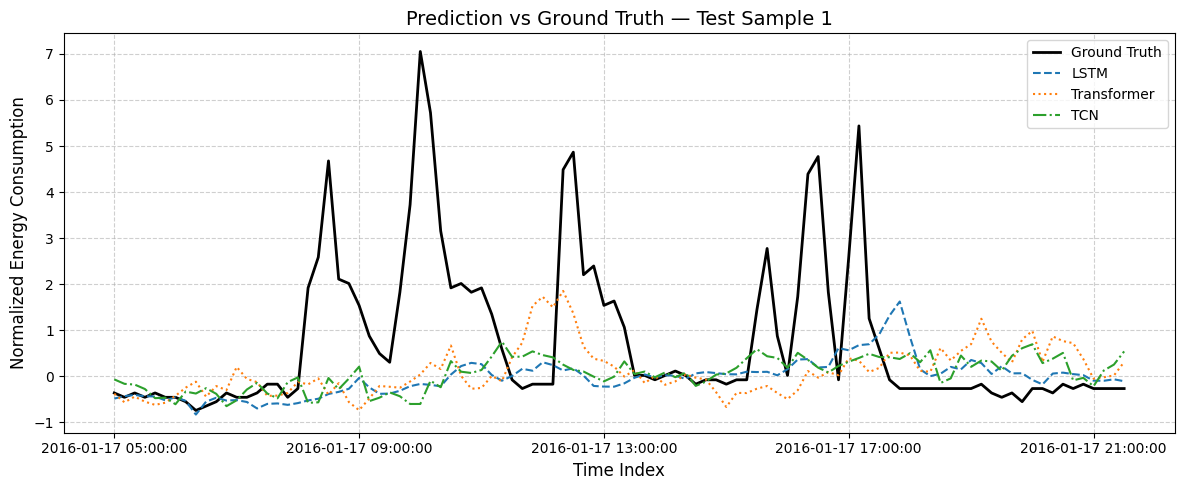

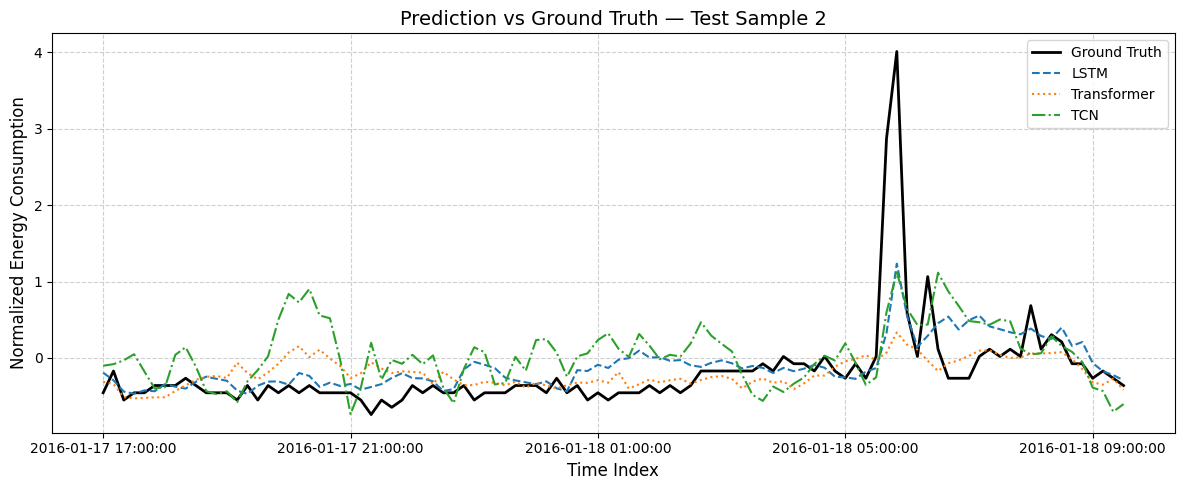

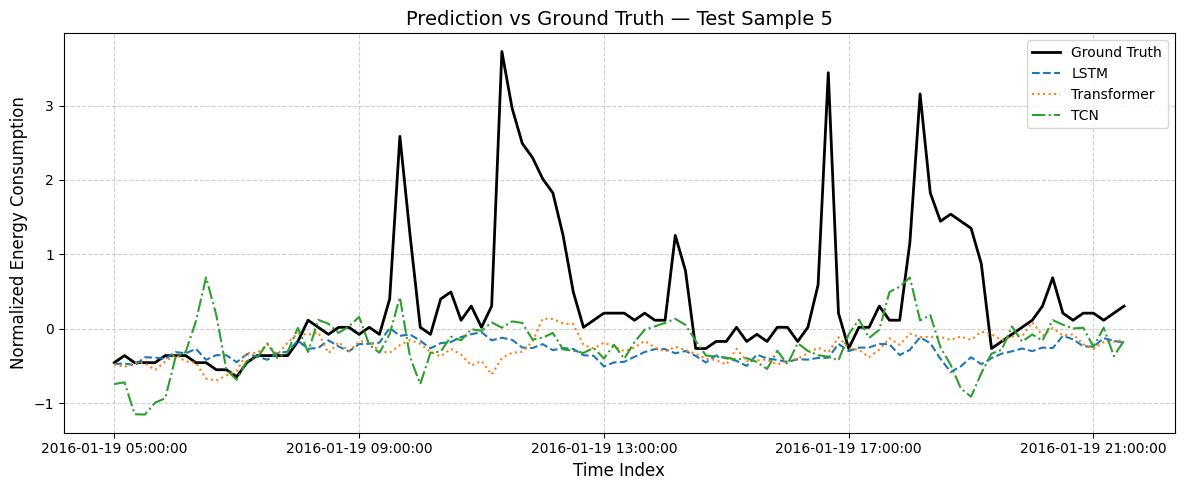

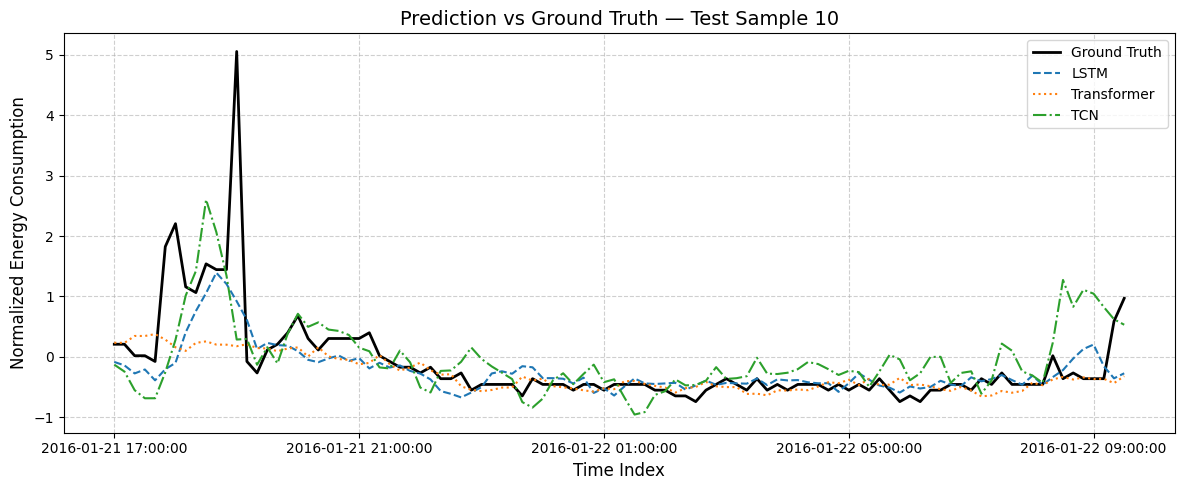

In [23]:
# SELECT THE TEST SAMPLE TO ANALYSE
TEST_SAMPLES = [0, 1, 2, 5, 10]  # you can choose any indices

# Plot predictions for each selected test sample
for TEST_SAMPLE in TEST_SAMPLES:
    start_idx = TEST_SAMPLE * stride + input_len
    time_range = df.index[start_idx : start_idx + horizon]

    plt.figure(figsize=(12, 5))
    plt.plot(time_range, results['lstm']['y_true'][TEST_SAMPLE], label='Ground Truth', linewidth=2, color='black')
    plt.plot(time_range, results['lstm']['y_pred'][TEST_SAMPLE], '--', label='LSTM', linewidth=1.5)
    plt.plot(time_range, results['transformer']['y_pred'][TEST_SAMPLE], ':', label='Transformer', linewidth=1.5)
    plt.plot(time_range, results['tcn']['y_pred'][TEST_SAMPLE], '-.', label='TCN', linewidth=1.5)

    plt.title(f"Prediction vs Ground Truth — Test Sample {TEST_SAMPLE}", fontsize=14)
    plt.xlabel("Time Index", fontsize=12)
    plt.ylabel("Normalized Energy Consumption", fontsize=12)

    # Reduce x-tick clutter
    step = 24  # every 4 hours
    tick_positions = time_range[::step]
    tick_labels = tick_positions.astype(str)
    plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=0)

    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# 🚀 Next Steps


This project establishes a solid baseline for time series forecasting using deep learning models. However, several opportunities remain to deepen the analysis and improve performance.

---

### 🔍 Exploratory Data Analysis (EDA)

- Perform a more comprehensive **correlation analysis** between external variables and target consumption to assess feature importance.
- Investigate **seasonal, weekly, and hourly patterns** to guide feature engineering and model design.
- Visualize **anomalies, outliers, or structural breaks** in the data that may require preprocessing or specialized modeling.
- Apply **dimensionality reduction techniques** (e.g., PCA, UMAP) to assess redundancy among input features.

---

### 🤖 Classical Machine Learning Models

- Integrate traditional statistical forecasting models for comparison:
  - **ARIMA**, **SARIMA**, and **Exponential Smoothing**
  - Models that explicitly capture seasonality and trend
- Implement **hybrid models** combining ARIMA for trend and DL for residual patterns.
- Evaluate the effect of **lag feature engineering** for tree-based regressors (e.g., XGBoost, LightGBM).

---

### 🧠 Deep Learning Optimization

- **Hyperparameter tuning:**
  - Apply **grid search** or **Bayesian optimization** to find optimal learning rates, dropout rates, layer sizes, etc.
- **Architectural improvements:**
  - Experiment with **deeper networks**, **attention mechanisms**, or **multi-resolution inputs**
- **Training strategies:**
  - Use **learning rate schedulers**, **early stopping**, and **batch normalization**
  - Experiment with **different loss functions** (e.g., Huber, quantile loss)

---

### 📈 Forecasting Horizon and Input Window

- Investigate the impact of **longer input windows** (e.g., 7–10 days) to improve long-term forecasting.
- Analyze the trade-off between **input length and model complexity** to avoid overfitting.
- Consider **multi-resolution input sequences** (e.g., daily + hourly patterns) for richer temporal context.

---

### 🧪 Evaluation and Validation

- Add **cross-validation over time** (e.g., rolling origin) to assess robustness.
- Monitor **temporal generalization** across seasons or time-of-day segments.
- Visualize **prediction intervals** or **uncertainty estimation** using quantile regression or dropout-based methods.

---

These directions aim to build a more robust, interpretable, and scalable forecasting pipeline suitable for deployment or further research.